In [48]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import linalg
import algoritmo_ncm as ncm
import sys
import os

In [49]:

class HiddenPrints:
    """Classe que desabilita prints dentro de funções"""
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [50]:
def gera_matrizes(n):
    #Devolve uma matriz inicial e a que queremos achar a ncm
    x = np.random.randn(n, n)
    g = np.random.randn(n, n)

    #A matriz a qual queremos encontrar a ncm mais proxima precisa ser simétrica 
    g = g@g.T
    return x,g 

In [51]:
def teste_solução(x,g,max_iter,tol):
#Função testa se a solução é valida
    x, iter = ncm.sm_ncm(x,g,max_iter,tol)
    if np.any(np.linalg.eigvals(x)) < -tol:
        print("não resolve")
    else: 
        print("resolve")

In [52]:
def media_iter(n,laps,max_iter,tol):
    lista_iter = []
    for i in range(laps):
        x,g  = gera_matrizes(n)
        with HiddenPrints():
            x, iter = ncm.sm_ncm(x,g,max_iter,tol)
        lista_iter.append(iter)
    media = np.mean(np.array(lista_iter))
    return lista_iter, media


In [64]:
# Gerar as matrizes fora do bloco timeit
n = 30
laps = 100
lista_g = []
lista_x0 = []
for i in range(laps):
    x0, g = gera_matrizes(n)
    lista_g.append(g)
    lista_x0.append(x0)

def mede_tempo(lista_x0,lista_g,laps,max_iter,tol):
    """Uma função que mede o tempo sem gerar as matrizes nem os vetores,o resultado é o tempo
    de 100 iterações"""
    with HiddenPrints():
        for i in range(laps):
            x, iter = ncm.sm_ncm(lista_x0[i],lista_g[i],max_iter,0.00001)
    return x

%timeit mede_tempo(lista_x0,lista_g,100,2000,0.00001)

13 s ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
import numpy as np
from func_auxiliares_ncm import *


def atualiza_diag_x(clarke, g):
    """Função responsável por fazer uma iteração do algoritmo"""
    df = np.linalg.inv(np.diag(np.diag(clarke)))@(e(clarke) - np.diag(clarke@sem_diag_g(g)))
    return df


def nearest_correlation_matrix(x_input, g_input, iter = 1000, tol = 10**(-6)):
    """Algoritmo de Nearest Correlation Matrix"""
    iteracao = 1
    X_anterior = x_input
    clarke = derivada_clarke(X_anterior)
    X_atual = np.diag(atualiza_diag_x(clarke, g_input)) + sem_diag_g(g_input)

    while iteracao < iter:
        iteracao = iteracao + 1
        X_anterior = X_atual
        clarke = derivada_clarke(X_anterior)
        X_atual = np.diag(atualiza_diag_x(clarke, g_input)) + sem_diag_g(g_input)

       # if np.linalg.norm(np.diag(derivada_clarke(X_atual) @ X_atual) - e(X_atual)) < tol:
       #     break
        if np.linalg.norm(derivada_clarke(X_atual) - clarke) < tol:
            break      
        
    return clarke @ X_atual, iteracao

In [38]:
import numpy as np

def projecao_S(R):

    eigvals, eigvecs = np.linalg.eigh(R)
    eigvals[eigvals < 0] = 0
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def projecao_U(Y):

    np.fill_diagonal(Y, 1)
    return Y

def projecoes_alternadas(G, max_iteracoes=1000):

    delta_S = np.zeros_like(G)
    X = G.copy()

    
    
    for k in range(1, max_iteracoes + 1):
        X_anterior = X.copy()

        R = X - delta_S
        
        # Projeta no subconjunto semidefinido
        Y = projecao_S(R)
        
        delta_S = Y - R
        
        # Projeta no subconjunto de diagonal unitária
        X = projecao_U(Y)
        
        # Critério de parada
        if np.linalg.norm(X - X_anterior) / np.linalg.norm(X) < 1e-6:
            break
        
        X_anterior = X.copy()
    return X,k



In [39]:
new_matrix = np.array([
    [2, -1, 0, 0],
    [-1, 2, -1, 0],
    [0, -1, 2, -1],
    [0, 0, -1, 2]
])

In [41]:
# Teste da função projeções alternadas com new_matrix
X_new, k = projecoes_alternadas(new_matrix)
print("Resultado da projeção alternada:")
print(X_new, "\nNúmero de iterações:", k, "\n")

# Teste da função sm_ncm com new_matrix
X_sm_ncm, iter_sm_ncm = nearest_correlation_matrix(X_new, new_matrix, 1000, 1e-6)
print("Resultado do sm_ncm:")
print(X_sm_ncm)
print("Número de iterações:", iter_sm_ncm)

Resultado da projeção alternada:
[[ 1.         -0.80841271  0.19158729  0.106775  ]
 [-0.80841271  1.         -0.65623329  0.19158729]
 [ 0.19158729 -0.65623329  1.         -0.80841271]
 [ 0.106775    0.19158729 -0.80841271  1.        ]] 
Número de iterações: 14 

Resultado do sm_ncm:
[[ 1.         -0.8084125   0.1915875   0.10677505]
 [-0.8084125   1.         -0.65623269  0.1915875 ]
 [ 0.1915875  -0.65623269  1.         -0.8084125 ]
 [ 0.10677505  0.1915875  -0.8084125   1.        ]]
Número de iterações: 2


In [43]:
import time

def gera_matriz_simetrica(n):
    """Gera uma matriz simétrica aleatória de dimensão n x n"""
    A = np.random.randn(n, n)
    return A @ A.T

def compara_algoritmos(dimensions, laps, max_iter, tol):
    resultados = []

    for n in dimensions:
        tempos_projecao = []
        iteracoes_projecao = []
        tempos_sm_ncm = []
        iteracoes_sm_ncm = []

        for _ in range(laps):
            G = gera_matriz_simetrica(n)

            # Teste de projeções alternadas
            start_time = time.time()
            X_proj, k_proj = projecoes_alternadas(G, max_iter)
            end_time = time.time()
            tempos_projecao.append(end_time - start_time)
            iteracoes_projecao.append(k_proj)

            # Teste de sm_ncm
            start_time = time.time()
            X_sm, iter_sm = nearest_correlation_matrix(G, G, max_iter, tol)
            end_time = time.time()
            tempos_sm_ncm.append(end_time - start_time)
            iteracoes_sm_ncm.append(iter_sm)

        resultados.append({
            'dimensao': n,
            'tempo_medio_projecao': np.mean(tempos_projecao),
            'iteracoes_media_projecao': np.mean(iteracoes_projecao),
            'tempo_medio_sm_ncm': np.mean(tempos_sm_ncm),
            'iteracoes_media_sm_ncm': np.mean(iteracoes_sm_ncm)
        })

    return resultados

# Definindo parâmetros
dimensions = [20, 40, 60, 80, 100]
laps = 10
max_iter = 10000000
tol = 1e-6

# Executando a comparação
resultados = compara_algoritmos(dimensions, laps, max_iter, tol)

# Exibindo os resultados
for resultado in resultados:
    print(f"Dimensão: {resultado['dimensao']}")
    print(f"Tempo médio (Projeção Alternada): {resultado['tempo_medio_projecao']:.6f} segundos")
    print(f"Iterações médias (Projeção Alternada): {resultado['iteracoes_media_projecao']:.2f}")
    print(f"Tempo médio (sm_ncm): {resultado['tempo_medio_sm_ncm']:.6f} segundos")
    print(f"Iterações médias (sm_ncm): {resultado['iteracoes_media_sm_ncm']:.2f}")
    print()


Dimensão: 20
Tempo médio (Projeção Alternada): 0.013480 segundos
Iterações médias (Projeção Alternada): 268.30
Tempo médio (sm_ncm): 0.005177 segundos
Iterações médias (sm_ncm): 45.30

Dimensão: 40
Tempo médio (Projeção Alternada): 0.071810 segundos
Iterações médias (Projeção Alternada): 469.50
Tempo médio (sm_ncm): 0.021335 segundos
Iterações médias (sm_ncm): 66.50

Dimensão: 60
Tempo médio (Projeção Alternada): 0.178645 segundos
Iterações médias (Projeção Alternada): 671.70
Tempo médio (sm_ncm): 0.047997 segundos
Iterações médias (sm_ncm): 78.40

Dimensão: 80
Tempo médio (Projeção Alternada): 0.392152 segundos
Iterações médias (Projeção Alternada): 806.10
Tempo médio (sm_ncm): 0.094994 segundos
Iterações médias (sm_ncm): 92.80

Dimensão: 100
Tempo médio (Projeção Alternada): 0.752033 segundos
Iterações médias (Projeção Alternada): 984.30
Tempo médio (sm_ncm): 0.161377 segundos
Iterações médias (sm_ncm): 99.80



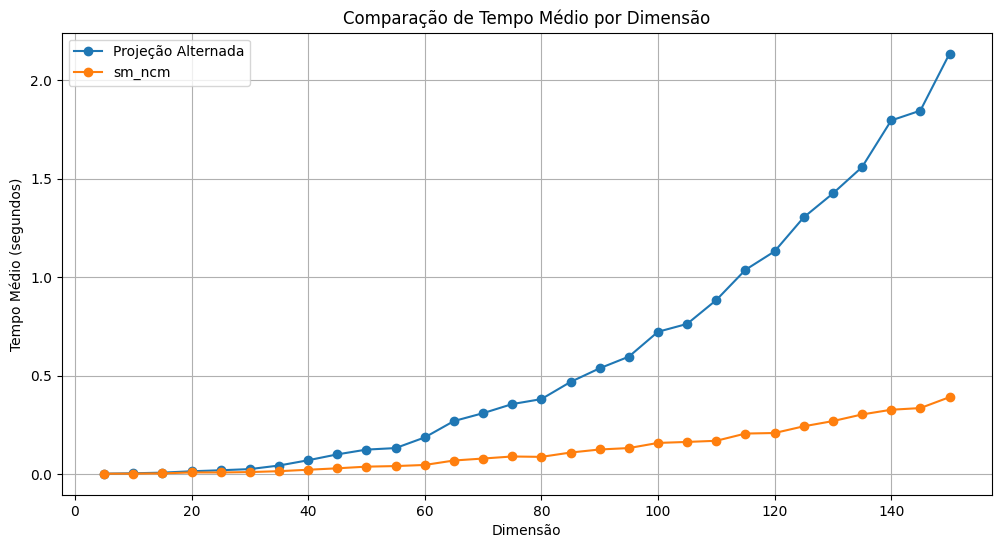

In [ ]:
import matplotlib.pyplot as plt

# Definindo novas dimensões
new_dimensions = list(range(5, 155, 5))

# Executando a comparação com as novas dimensões
new_resultados = compara_algoritmos(new_dimensions, laps, max_iter, tol)

# Criando listas para armazenar os tempos médios e número de iterações
tempos_medio_projecao = []
iteracoes_media_projecao = []
tempos_medio_sm_ncm = []
iteracoes_media_sm_ncm = []

for resultado in new_resultados:
    tempos_medio_projecao.append(resultado['tempo_medio_projecao'])
    iteracoes_media_projecao.append(resultado['iteracoes_media_projecao'])
    tempos_medio_sm_ncm.append(resultado['tempo_medio_sm_ncm'])
    iteracoes_media_sm_ncm.append(resultado['iteracoes_media_sm_ncm'])

# Plotando o gráfico de tempo por dimensões comparando os dois algoritmos
plt.figure(figsize=(12, 6))
plt.plot(new_dimensions, tempos_medio_projecao, label='Projeção Alternada', marker='o')
plt.plot(new_dimensions, tempos_medio_sm_ncm, label='Newton Semi-suave', marker='o')
plt.xlabel('Dimensão')
plt.ylabel('Tempo Médio (segundos)')
plt.title('Comparação de Tempo Médio por Dimensão')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Definindo novas dimensões altas
high_dimensions = [10,20,40,80,160]

# Executando a comparação com as novas dimensões altas
high_resultados = compara_algoritmos(high_dimensions, laps, max_iter, tol)

# Exibindo os resultados
for resultado in high_resultados:
    print(f"Dimensão: {resultado['dimensao']}")
    print(f"Tempo médio (Projeção Alternada): {resultado['tempo_medio_projecao']:.6f} segundos")
    print(f"Iterações médias (Projeção Alternada): {resultado['iteracoes_media_projecao']:.2f}")
    print(f"Tempo médio (sm_ncm): {resultado['tempo_medio_sm_ncm']:.6f} segundos")
    print(f"Iterações médias (sm_ncm): {resultado['iteracoes_media_sm_ncm']:.2f}")
    print()

Dimensão: 10
Tempo médio (Projeção Alternada): 0.003447 segundos
Iterações médias (Projeção Alternada): 115.40
Tempo médio (sm_ncm): 0.001670 segundos
Iterações médias (sm_ncm): 24.10

Dimensão: 20
Tempo médio (Projeção Alternada): 0.012928 segundos
Iterações médias (Projeção Alternada): 269.20
Tempo médio (sm_ncm): 0.005297 segundos
Iterações médias (sm_ncm): 48.20

Dimensão: 40
Tempo médio (Projeção Alternada): 0.070828 segundos
Iterações médias (Projeção Alternada): 478.10
Tempo médio (sm_ncm): 0.023077 segundos
Iterações médias (sm_ncm): 70.40

Dimensão: 80
Tempo médio (Projeção Alternada): 0.402093 segundos
Iterações médias (Projeção Alternada): 835.50
Tempo médio (sm_ncm): 0.090352 segundos
Iterações médias (sm_ncm): 89.50

Dimensão: 160
Tempo médio (Projeção Alternada): 2.491446 segundos
Iterações médias (Projeção Alternada): 1481.20
Tempo médio (sm_ncm): 0.443707 segundos
Iterações médias (sm_ncm): 123.00



In [53]:
import pandas as pd

# Criando o dataframe com os resultados de compara_algoritmos
df_resultados

# Criando o dataframe com os resultados de high_dimensions
df_high_resultados = pd.DataFrame(high_resultados)

# Exibindo os dataframes
print("Dataframe com os resultados de compara_algoritmos:")
print(df_resultados)
print("\nDataframe com os resultados de high_dimensions:")
print(df_high_resultados)

Dataframe com os resultados de compara_algoritmos:
   dimensao  tempo_medio_projecao  iteracoes_media_projecao  \
0        20              0.013480                     268.3   
1        40              0.071810                     469.5   
2        60              0.178645                     671.7   
3        80              0.392152                     806.1   
4       100              0.752033                     984.3   

   tempo_medio_sm_ncm  iteracoes_media_sm_ncm  
0            0.005177                    45.3  
1            0.021335                    66.5  
2            0.047997                    78.4  
3            0.094994                    92.8  
4            0.161377                    99.8  

Dataframe com os resultados de high_dimensions:
   dimensao  tempo_medio_projecao  iteracoes_media_projecao  \
0        10              0.003417                     124.4   
1        20              0.012243                     245.3   
2        40              0.066436           

In [54]:
# Filtrando os dataframes para incluir apenas as colunas de dimensão e tempo médio
df_resultados_tempo = df_resultados[['dimensao', 'tempo_medio_projecao', 'tempo_medio_sm_ncm']]
df_high_resultados_tempo = df_high_resultados[['dimensao', 'tempo_medio_projecao', 'tempo_medio_sm_ncm']]

# Exibindo os dataframes filtrados
print("Dataframe com os tempos médios de compara_algoritmos:")
print(df_resultados_tempo)
print("\nDataframe com os tempos médios de high_dimensions:")
print(df_high_resultados_tempo)

Dataframe com os tempos médios de compara_algoritmos:
   dimensao  tempo_medio_projecao  tempo_medio_sm_ncm
0        20              0.013480            0.005177
1        40              0.071810            0.021335
2        60              0.178645            0.047997
3        80              0.392152            0.094994
4       100              0.752033            0.161377

Dataframe com os tempos médios de high_dimensions:
   dimensao  tempo_medio_projecao  tempo_medio_sm_ncm
0        10              0.003417            0.002065
1        20              0.012243            0.004698
2        40              0.066436            0.020502
3        80              0.383592            0.086846
4       150              2.052055            0.374790


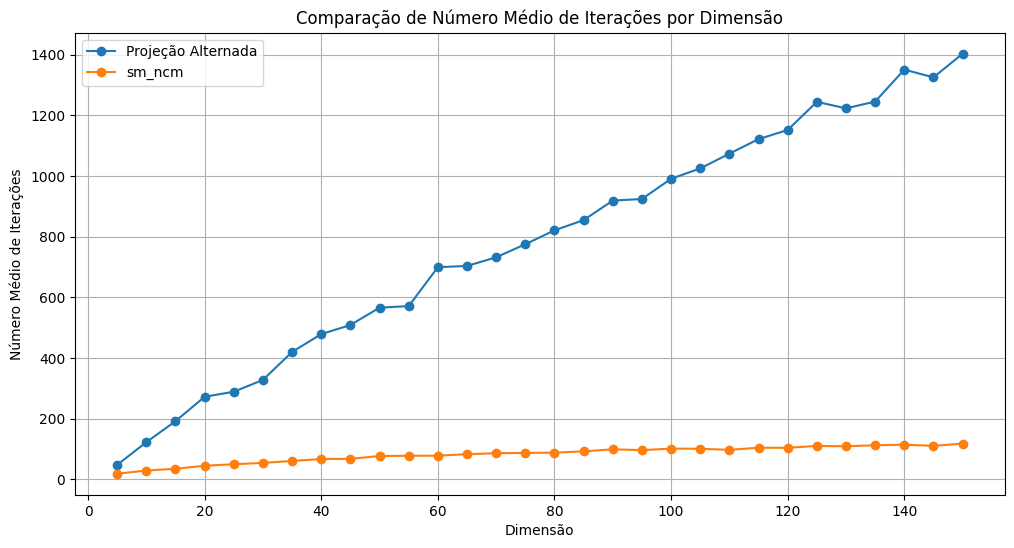

In [47]:
# Criando listas para armazenar o número de iterações
iteracoes_media_projecao = []
iteracoes_media_sm_ncm = []

for resultado in new_resultados:
    iteracoes_media_projecao.append(resultado['iteracoes_media_projecao'])
    iteracoes_media_sm_ncm.append(resultado['iteracoes_media_sm_ncm'])

# Plotando o gráfico de número de iterações por dimensões comparando os dois algoritmos
plt.figure(figsize=(12, 6))
plt.plot(new_dimensions, iteracoes_media_projecao, label='Projeção Alternada', marker='o')
plt.plot(new_dimensions, iteracoes_media_sm_ncm, label='sm_ncm', marker='o')
plt.xlabel('Dimensão')
plt.ylabel('Número Médio de Iterações')
plt.title('Comparação de Número Médio de Iterações por Dimensão')
plt.legend()
plt.grid(True)
plt.show()